Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [3]:
X

array([[1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 1.00e+00, 2.00e+00, 1.00e+00, 3.00e+00, 0.00e+00,
        5.00e+00, 1.00e+01, 1.00e+00, 2.00e+00],
       [5.00e+02, 7.00e+02, 7.50e+02, 6.00e+02, 1.45e+03, 8.00e+02,
        1.50e+03, 2.00e+03, 4.50e+02, 1.00e+03],
       [1.00e+00, 1.00e+00, 2.00e+00, 1.00e+00, 2.00e+00, 1.00e+00,
        3.00e+00, 3.00e+00, 1.00e+00, 2.00e+00]])

In [4]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

In [5]:
X_st = X.copy()
X_st[2, :] = calc_std_feat(X[2, :])

In [6]:
X_st[2, :].std()

0.9999999999999999

In [7]:
def calc_logloss(y, y_pred):
    y_pred_min = 1e-4
    y_pred_max = 1 - 1e-4
    y_pred = np.clip(y_pred, y_pred_min, y_pred_max)
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [8]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [9]:
def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W

In [10]:
eval_model(X_st, y, iterations=100000, alpha=1e-5)

100000 [ 0.25809285 -0.68188567  0.6883469   1.2412009 ] 0.5906726973128931


array([ 0.25809285, -0.68188567,  0.6883469 ,  1.2412009 ])

Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [11]:
def eval_model(X, y, iterations, alpha=1e-4, tolerance = 1e-6):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    logloss = []
    weights = []
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W = W - alpha * (1/n * np.dot((y_pred - y), X.T))
        weights.append(W)
        logloss.append(err)
        
        
        if i > 2:
            if np.abs(logloss[i-1] - logloss[i-2]) < tolerance:
                break
    
    return logloss, weights

In [12]:
def plot_err(logloss, weights):
    fig= plt.figure(figsize=(15,5))
    plt.suptitle(f'Optional rounds: {len(logloss)}, Errors: {round(logloss[-1], 2)}', size = 15)
    
    plt.subplot(121)
    plt.plot(logloss, linewidth = 3)
    plt.xlabel('n_iterations', size = 15)
    plt.ylabel('error', size = 15)
    
    plt.subplot(122)
    plt.plot(weights, linewidth = 3)
    plt.legend([f'$w_{i}$' for i in range(len(weights[0]))], loc = 'best',fontsize = 15)
    plt.xlabel('n_iterations', size = 15)
    plt.ylabel('w', size = 15)
    plt.show()

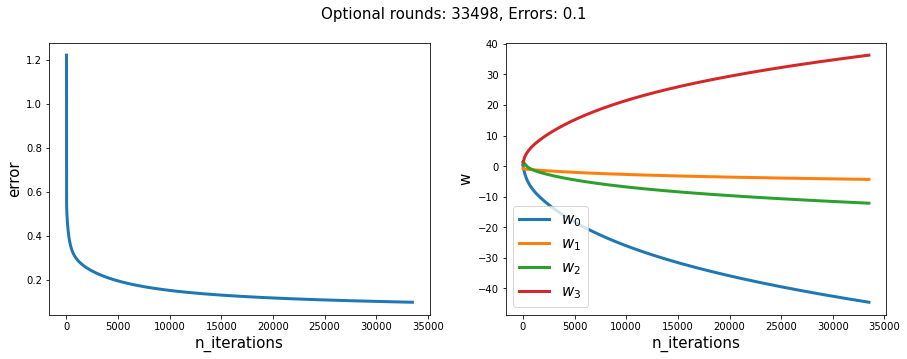

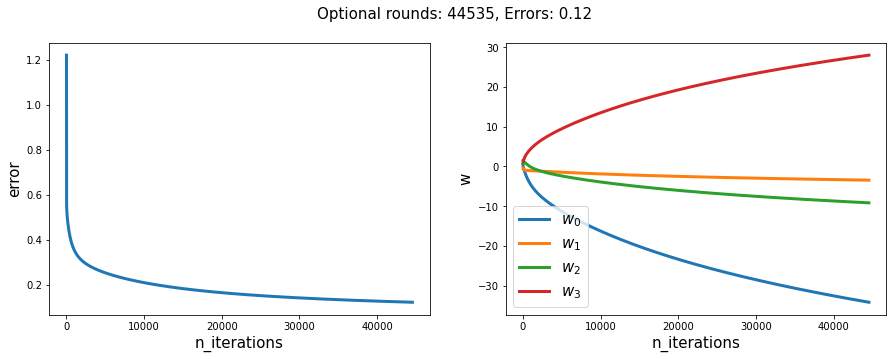

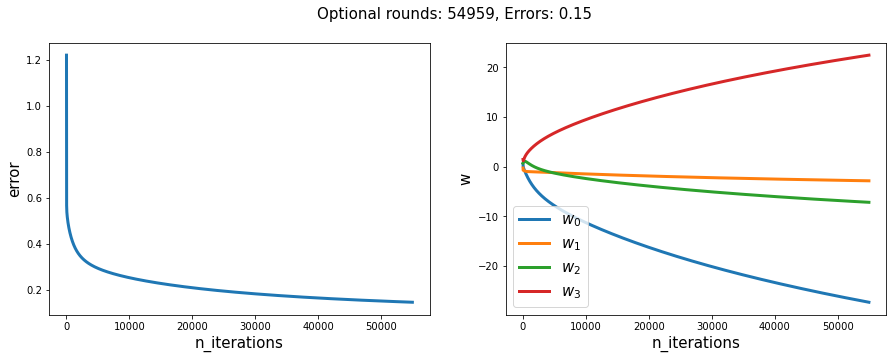

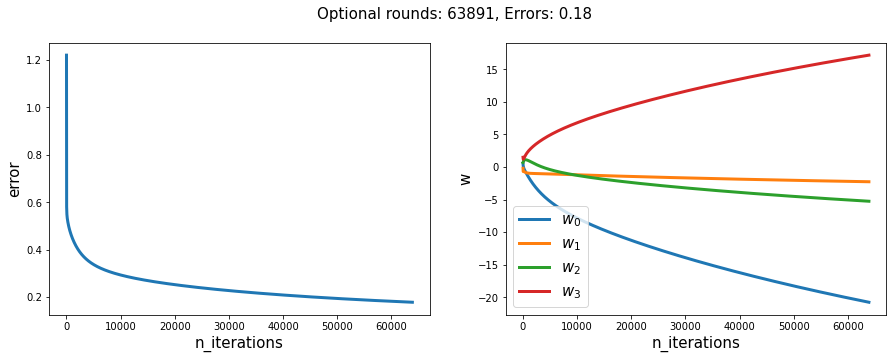

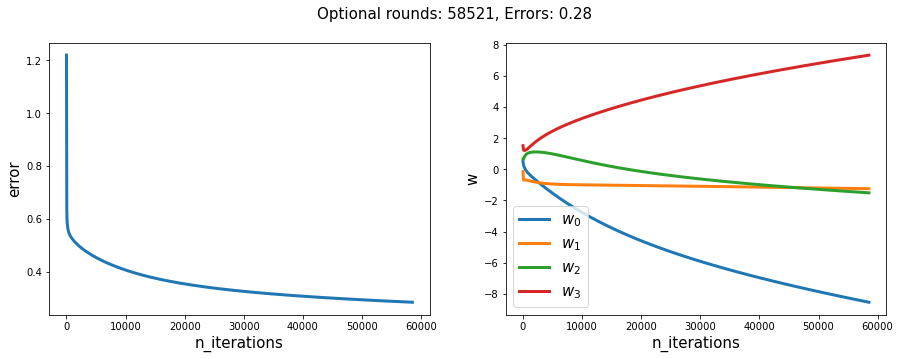

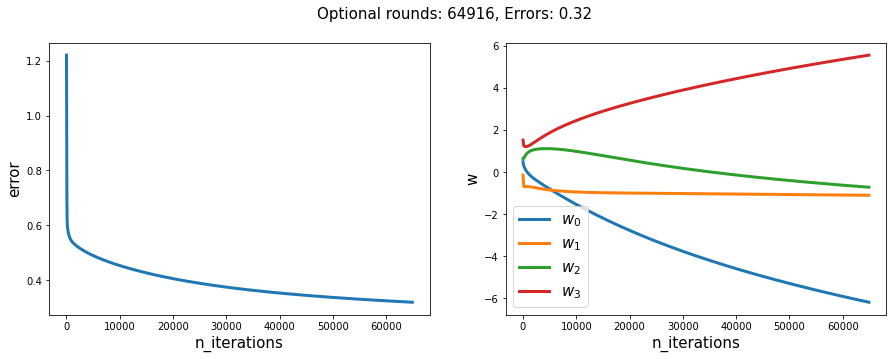

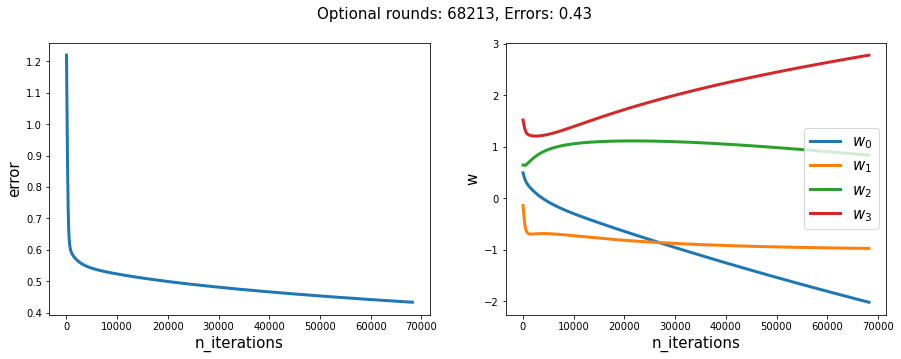

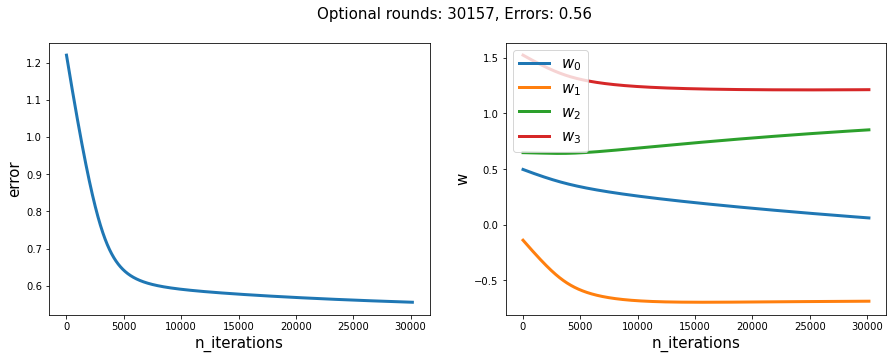

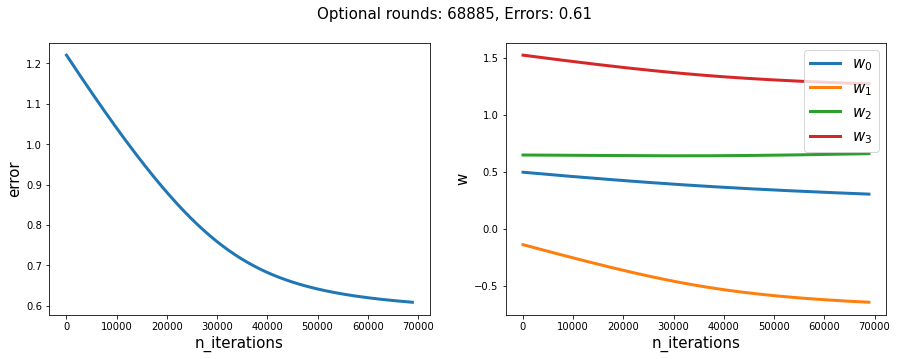

In [13]:
for alpha in [0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001, 0.00001]:
    W = eval_model(X_st, y, iterations=100000, alpha=alpha, tolerance = 1e-6)
    plot_err(W[0], W[1])

Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [14]:
def calc_pred_proba(W, X):
    z = np.dot(W,X)
    return 1/(1 + np.exp(-z))

In [15]:
W = eval_model(X_st, y, iterations=100000, alpha=0.5, tolerance = 1e-6)

In [16]:
calc_pred_proba(W[1][-1], X_st)

array([0.33657718, 0.00339617, 1.        , 0.03991975, 0.96077451,
       0.02090311, 1.        , 0.00994178, 0.63926958, 0.99999999])

Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [17]:
def calc_pred(W, X, treshold = 0.5):
    y_pred = calc_pred_proba(W, X)
    y_pred = np.where(y_pred > treshold, 1, 0 )
    return y_pred

In [18]:
y_pred = calc_pred(W[1][-1], X_st)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [19]:
accuracy = np.sum(y_pred)/y_pred.shape[0] # accuracy
accuracy

0.5

In [22]:
conf_matrix = np.array(pd.crosstab(y, y_pred)) # матрица ошибок
conf_matrix

array([[5, 0],
       [0, 5]])

In [23]:
precition = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[0,1]) # точность 
precition

1.0

In [24]:
recall = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]) # полнота
recall

1.0

In [25]:
F = 2 * precition * recall / (precition + recall)
F

1.0

Могла ли модель переобучиться? Почему?
могла бы если бы:

- в истинных значениях были выбросы и мы не делали регуляризацию,
- было мало данных
- была сильная кореляция в данных